In [1]:
!git clone https://github.com/Mike030668/Project_glass.git -q

In [2]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  import os
  os.chdir('/content/Project_glass')
  os.getcwd()

else:
  print('Not running on CoLab')

Running on CoLab


In [12]:
from prepare_data.conts_predtrend import WIND_SED, RATIO, DEPTH, PREDICT_LAG, BATCH_SIZE
from prepare_data.constants import GLASS_COLS, FUTURE, MAIN_COLS
from prepare_data.trend_utils import Gaussignal
from prepare_data.utils import split_sequence
from utils.estimation import confusion_matrix
import numpy as np # библиотека нампи
import matplotlib.pyplot as plt # библиотека матплотлиб для отрисовки
from IPython.display import clear_output # очистка вывода в ячейке
import joblib
import pandas as pd # библиотека пандас
import tensorflow as tf           # библиотека машинного обучения

# load prepared train data

data prepared with vcs note makedata_vsc.ipynb

In [4]:
x_train_sc = np.load("./predtrend/x_train_sc.npy")
x_val_sc = np.load("./predtrend/x_val_sc.npy")
y_train_sc = np.load("./predtrend/y_train_sc.npy")
y_val_sc = np.load("./predtrend/y_val_sc.npy")
y_data = np.load("./predtrend/y_data.npy")

In [5]:
from construct_model.make_models import baseline, model_trendpath_colab

model= baseline(input_shape = x_val_sc.shape[1:],
                    pred_num = PREDICT_LAG,
                    activ_hid_1="tanh",
                    activ_hid_2 = 'tanh',
                    activ_out = "tanh",
                    depth= DEPTH)


In [6]:
# понижение шага
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 mode='min',
                                                 factor = 0.8,
                                                 patience = 3,
                                                 min_lr = 1e-9,
                                                 verbose = 1)

# остановка
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)

path_model = model_trendpath_colab

# Сохранение модели
checkpoint  = tf.keras.callbacks.ModelCheckpoint(
                        filepath = path_model,
                        #save_weights_only=True,
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True
                        )
# оптимизатор
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)

# функция потерь
loss = tf.keras.losses.Huber() #.MSE #
model.compile(optimizer = optimizer, loss = loss, metrics=['mae'])

In [7]:
# обучение модели вашей
history = model.fit(x_train_sc, y_train_sc,                  # генератор данных для обучения
                    validation_data=(x_val_sc, y_val_sc), # генератор данных для проверки
                    batch_size=BATCH_SIZE,
                    epochs = 200,
                    callbacks=[early_stopping, reduce_lr, checkpoint],
                    verbose = 1)

Epoch 1/200
35/35 [==============================] - 23s 374ms/step - loss: 0.1519 - mae: 0.4393 - val_loss: 0.1673 - val_mae: 0.4792 - lr: 0.0010
Epoch 2/200
35/35 [==============================] - 11s 319ms/step - loss: 0.0995 - mae: 0.3474 - val_loss: 0.1566 - val_mae: 0.4646 - lr: 0.0010
Epoch 3/200
35/35 [==============================] - 10s 301ms/step - loss: 0.0673 - mae: 0.2847 - val_loss: 0.1503 - val_mae: 0.4539 - lr: 0.0010
Epoch 4/200
35/35 [==============================] - 1s 21ms/step - loss: 0.0469 - mae: 0.2358 - val_loss: 0.1547 - val_mae: 0.4594 - lr: 0.0010
Epoch 5/200
35/35 [==============================] - 1s 17ms/step - loss: 0.0389 - mae: 0.2144 - val_loss: 0.1580 - val_mae: 0.4683 - lr: 0.0010
Epoch 6/200
32/35 [==========================>...] - ETA: 0s - loss: 0.0315 - mae: 0.1916
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.000800000037997961.
35/35 [==============================] - 1s 16ms/step - loss: 0.0313 - mae: 0.1910 - val_loss: 0.1566 - 

In [8]:
pred = model.predict(x_val_sc, verbose=False)
pred_signal = np.squeeze(pred)

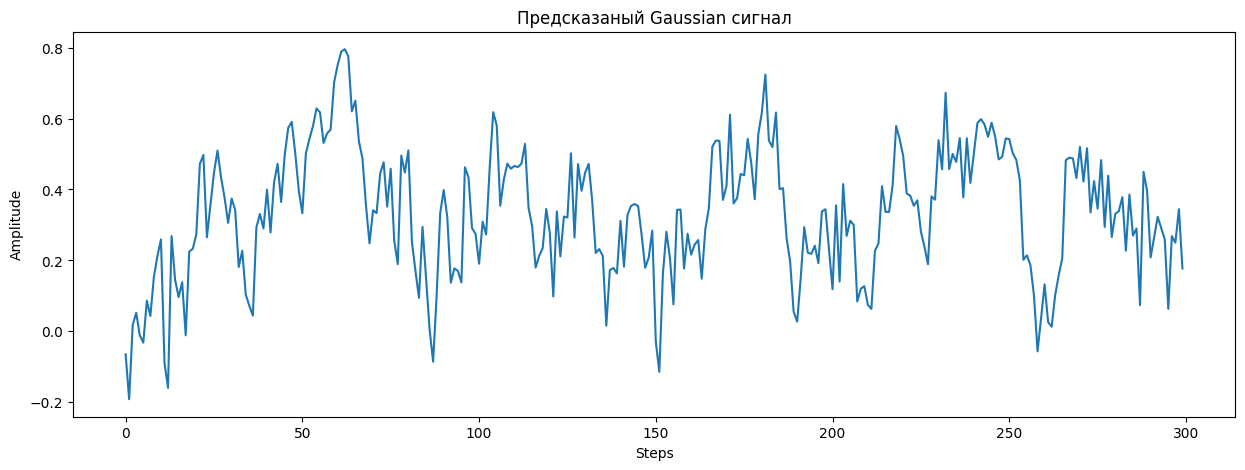

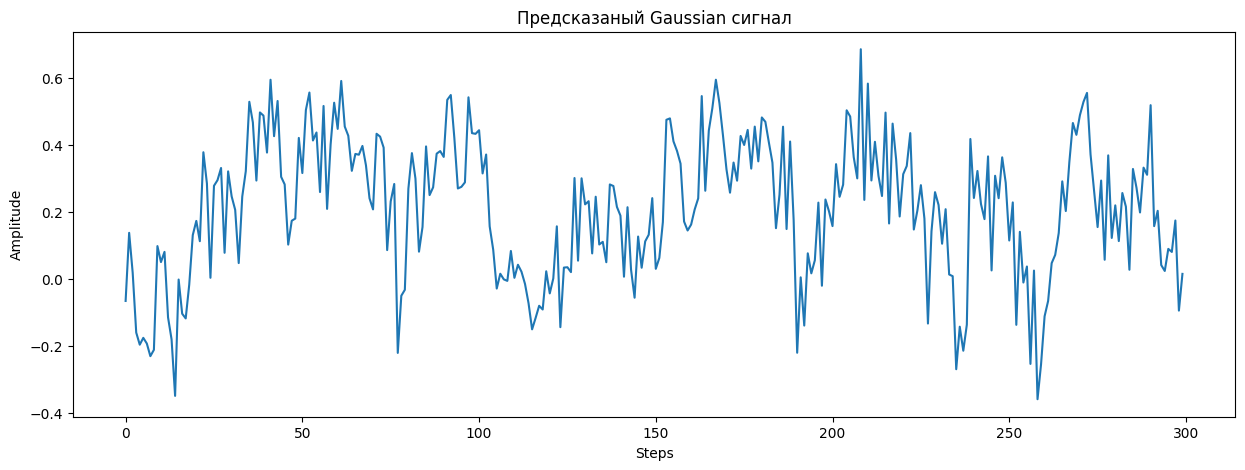

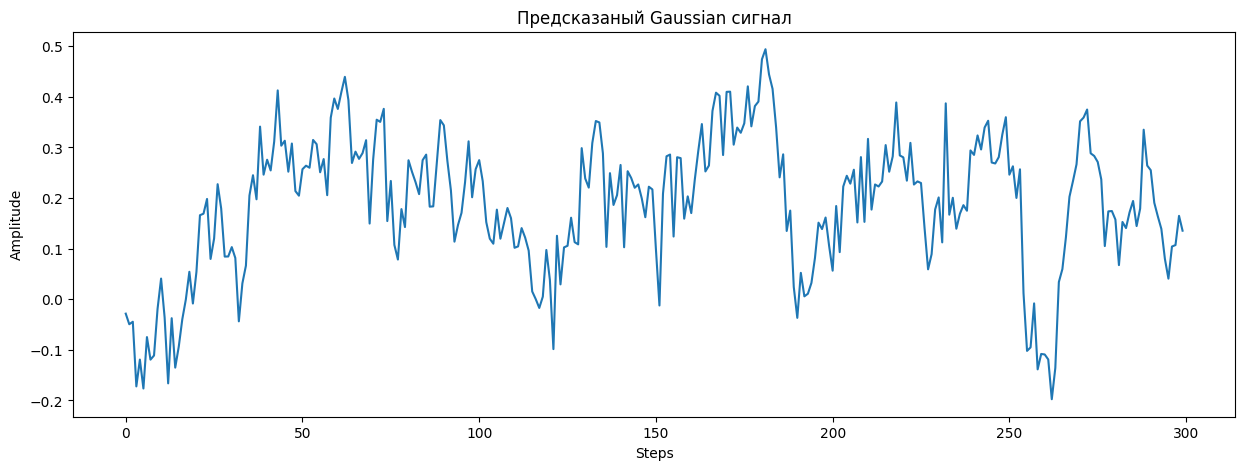

In [9]:
gd = Gaussignal(y_val_sc[:,0])
gd.plot_gausdata(100, 400, pred_signal[:,0], title="pred")
gd.plot_gausdata(100, 400, pred_signal[:,4], title="pred")
gd.plot_gausdata(100, 400, pred_signal.mean(1), title="pred")

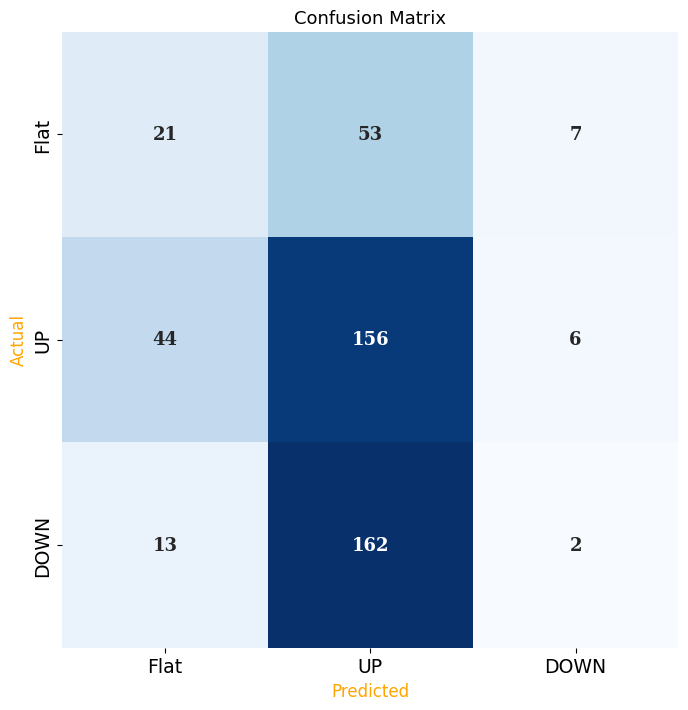

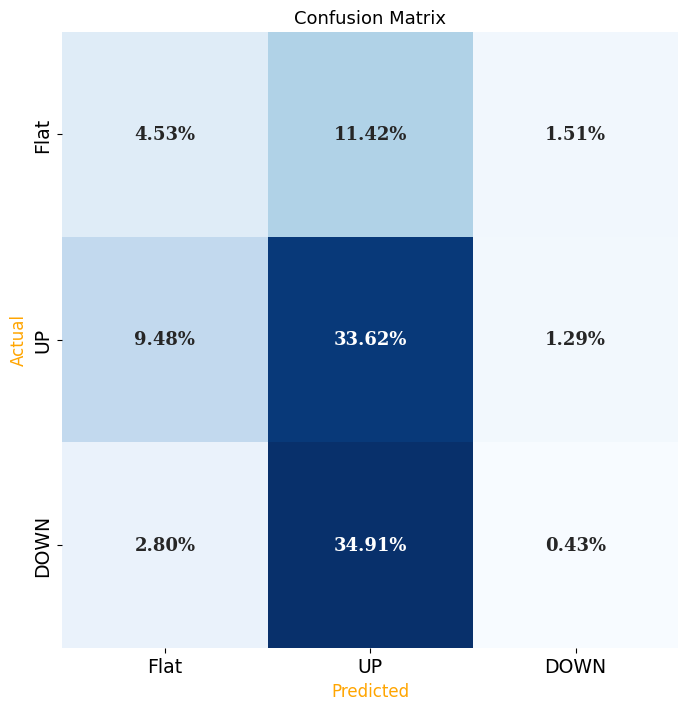

In [10]:
# устанавливаем переход от ожидания к действию
TRESH_UP = 0.1
TRESH_DOWN = -0.1
VAL_LEN = 500
lag = 1
#test_signal = pred_signal[:,lag]
test_signal = pred_signal.mean(1)
# переведем сигнал от нейронки в класс действия
y_pred = np.zeros(pred_signal.shape[0])
y_pred[test_signal > TRESH_UP] = 1
y_pred[test_signal < TRESH_DOWN] = 2

# переведем сигнал от разметки  в класс действия
y_true_ = y_data[-1-VAL_LEN+DEPTH+lag:-PREDICT_LAG+lag]
y_true = np.zeros(y_true_.shape[0])
y_true[y_true_==1] = 1
y_true[y_true_== -1] = 2

# строим матрицу ошибок
confusion_matrix(y_true, y_pred, labels=['Flat', 'UP', 'DOWN'], figsize=(8,8))
confusion_matrix(y_true, y_pred, labels=['Flat', 'UP', 'DOWN'], normalize='all', figsize=(8,8))

## Тест модели на TEST данных

## Готовим производные данных

In [11]:
all_data = pd.read_csv("/content/Project_glass/stock_data/BTCUSDT_1 _min.csv",
                       index_col=0, parse_dates=True )
print(f'Размер данных {all_data.shape}')

TEST_SIZE = 1500 # для теста откусим последние test_size значений
# Тестовая выборка для симуляции торговли в реальном времени
print(f'Тестовый датасет')
TEST_DATASET = all_data[FUTURE-PREDICT_LAG: FUTURE + TEST_SIZE]
print(TEST_DATASET.shape)


Размер данных (8317, 54)
Тестовый датасет
(1505, 54)


### Готовим данные из df_test

In [14]:
# колонки для тренировочной выборки
TRAIN_COLUMNS = MAIN_COLS + GLASS_COLS
GLASS = len(GLASS_COLS)

X_MAIN_SCALER = joblib.load("/content/Project_glass/predtrend/x_main_scailer.save")
X_GLASS_SCALER = joblib.load("/content/Project_glass/predtrend/x_glass_scailer.save")


x_test = TEST_DATASET[TRAIN_COLUMNS].values

x_test_sc = np.zeros_like(x_test)
x_test_sc[:,:-GLASS] = X_MAIN_SCALER.transform(x_test[:,:-GLASS])  # трансформируем x_train
x_test_sc[:,-GLASS:] = X_GLASS_SCALER.transform(x_test[:,-GLASS:])  # трансформируем x_train


print(x_test_sc.shape)
x_test_sc[0]

(1505, 54)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


array([5.12777110e-01, 5.30849761e-01, 5.59224585e-01, 5.36747843e-01,
       2.85110270e-01, 9.81148492e-01, 3.32928467e-01, 2.46189953e-01,
       2.76011547e-01, 3.84728429e-01, 5.69884801e-01, 8.07079646e-01,
       8.11320755e-01, 1.88679245e-01, 7.68037975e-01, 7.95371498e-01,
       2.04628502e-01, 2.69424791e-01, 5.21968014e-02, 3.65033934e-02,
       2.31017217e-03, 2.18156433e-04, 2.71053833e-03, 1.02877507e-02,
       1.05207576e-01, 2.47634639e-03, 5.61413268e-03, 4.30167247e-03,
       1.17228464e-02, 4.94310137e-02, 2.06234675e-02, 2.42760988e-02,
       2.99349099e-02, 1.06172952e-01, 5.20451816e-02, 1.11401650e-01,
       1.32959219e-01, 5.38009083e-02, 4.07870646e-02, 3.22196288e-03,
       1.52350576e-02, 3.11758592e-02, 4.21240090e-03, 2.56698160e-02,
       4.14293135e-02, 1.81756318e-02, 7.31905436e-03, 1.82933279e-01,
       1.31749229e-01, 1.70422807e-01, 1.69260314e-01, 1.08501230e-01,
       1.08878697e-01, 1.83241924e-01])

In [15]:
pred_test = model.predict(x_test_sc, verbose=False)
pred_test_signal = np.squeeze(pred_test)

InvalidArgumentError: Graph execution error:

Detected at node model/tf.__operators__.getitem_4/strided_slice defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-15-86725ed244e2>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2655, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/tf_op_layer.py", line 536, in _call_wrapper

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/tf_op_layer.py", line 242, in _call_wrapper

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/tf_op_layer.py", line 279, in _call_wrapper

Index out of range using input dim 2; input has only 2 dims
	 [[{{node model/tf.__operators__.getitem_4/strided_slice}}]] [Op:__inference_predict_function_56793]